# Malarie Diagonasis Project

### Import Packages 

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import tensorflow_datasets as tfds

In [ ]:
# %pip uninstall -y tensorflow-datasets
# %pip install --upgrade tensorflow-datasets
# # import wandb


In [ ]:
# import wandb
# from wandb.integration.keras import WandbCallback

In [4]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

In [5]:
dataset[0] 

<PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
for data in dataset[0].take(1):
  print(data)
  print(data[0].shape)

(<tf.Tensor: shape=(145, 148, 3), dtype=uint8, numpy=
array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)>, <tf.Tensor: shape=(), dtype=int64, numpy=1>)
(145, 148, 3)


In [7]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [8]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

In [9]:
train_dataset

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

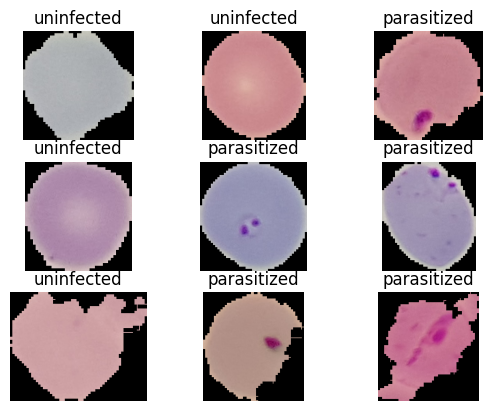

In [10]:
for i, (image, label) in enumerate(train_dataset.take(9)):
  ax = plt.subplot(3, 3, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

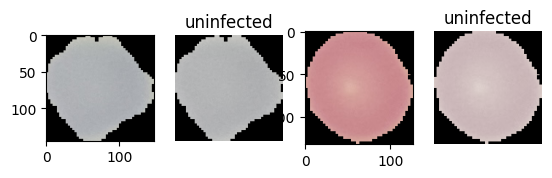

In [11]:
for i, (image, label) in enumerate(train_dataset.take(2)):
  plt.subplot(1, 4, 2*i + 1)
  plt.imshow(image)

  plt.subplot(1, 4, 2*i + 2)
  plt.imshow(tf.image.adjust_saturation(image, 0.3))


  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [12]:
train_dataset

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [13]:
IM_SIZE = 224

In [14]:
original_image, label = next(iter(train_dataset))
@tf.function
def resize_rescale(image, label):
  #print("I was here")
  #tf.print("I was here")
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

_, _ = resize_rescale(original_image, label)
_, _ = resize_rescale(original_image, label)

In [15]:
@tf.function
def augment(image, label):
  image, label = resize_rescale(image, label)

  image = tf.image.rot90(image)
  image = tf.image.adjust_saturation(image, saturation_factor = 0.3)
  image = tf.image.flip_left_right(image)

  return image, label

In [ ]:
# train_dataset = train_dataset.map(augment, num_parallel_calls = tf.data.AUTOTUNE)

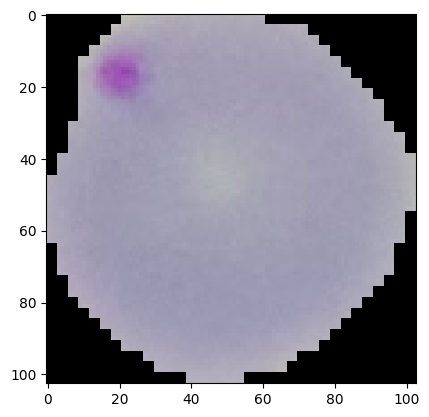

In [16]:
for image,label in train_dataset.take(1):
  plt.imshow(image)
  # print(image, label)

In [17]:
BATCH_SIZE = 32

In [18]:
train_dataset = train_dataset.map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE).shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE).shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.map(resize_rescale, num_parallel_calls = tf.data.AUTOTUNE).shuffle(buffer_size=8,reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [19]:
IM_SIZE = 224
BATCH_SIZE = 32

### Sequential Model

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(IM_SIZE, IM_SIZE, 3)),
    
    tf.keras.layers.Conv2D(filters=6, kernel_size=5, padding= 'valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Conv2D(filters=16, kernel_size=5, padding= 'valid', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.MaxPool2D(pool_size=2, strides=2),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(units=100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
  ])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Batc  (None, 106, 106, 16)     64        
 hNormalization)                                                 
                                                        

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics= tf.keras.metrics.BinaryAccuracy())

In [ ]:
history = model.fit(train_dataset,
                  epochs=10,
                  validation_data=val_dataset,
                  verbose=1)

Epoch 1/10
689/689 [==============================] - 64s 38ms/step - loss: 0.3395 - binary_accuracy: 0.8574 - val_loss: 0.3296 - val_binary_accuracy: 0.9165
Epoch 2/10
689/689 [==============================] - 25s 36ms/step - loss: 0.1868 - binary_accuracy: 0.9383 - val_loss: 0.4499 - val_binary_accuracy: 0.5702
Epoch 3/10
689/689 [==============================] - 25s 36ms/step - loss: 0.1666 - binary_accuracy: 0.9464 - val_loss: 0.1723 - val_binary_accuracy: 0.9477
Epoch 4/10
689/689 [==============================] - 25s 36ms/step - loss: 0.1499 - binary_accuracy: 0.9536 - val_loss: 0.1721 - val_binary_accuracy: 0.9463
Epoch 5/10
689/689 [==============================] - 25s 36ms/step - loss: 0.1411 - binary_accuracy: 0.9552 - val_loss: 0.1580 - val_binary_accuracy: 0.9470
Epoch 6/10
689/689 [==============================] - 25s 36ms/step - loss: 0.1362 - binary_accuracy: 0.9560 - val_loss: 0.1781 - val_binary_accuracy: 0.9525
Epoch 7/10
689/689 [==============================] 

In [ ]:
model.evaluate(test_dataset)

87/87 [==============================] - 4s 19ms/step - loss: 0.1751 - binary_accuracy: 0.9467


[0.17512662708759308, 0.9466812014579773]

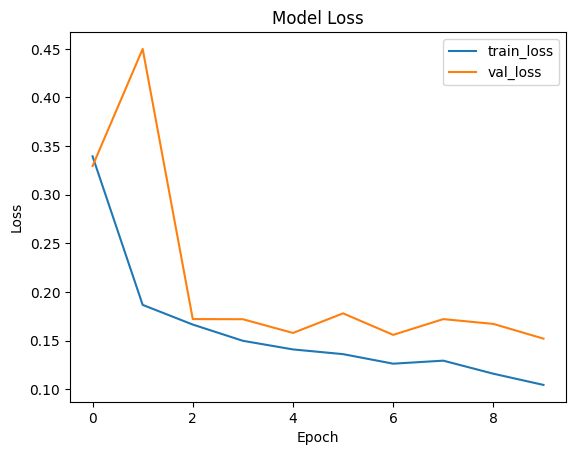

In [ ]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

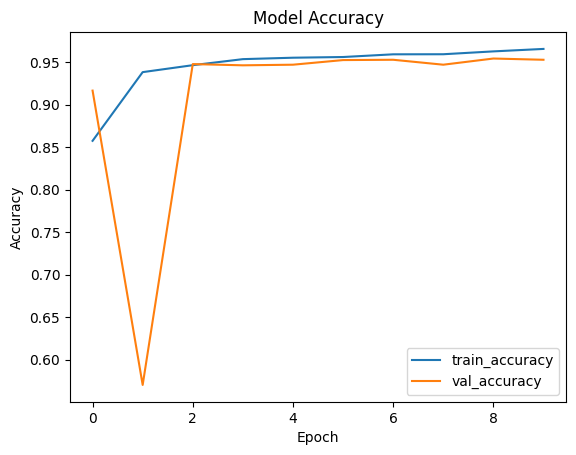

In [ ]:
plt.plot(history.history['binary_accuracy'], label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], label='val_binary_accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
def parasite_prediction(x):
    if x < 0.5:
        return "Parasite"
    else:
        return "Uninfected"

In [ ]:
model.predict(test_dataset.take(1))[0][0]  # Predicting on a single image from the test dataset

1/1 [==============================] - 2s 2s/step


0.00022993797

In [ ]:
print(parasite_prediction(model.predict(test_dataset.take(2))[0][0]))  # Predicting on a single image from the test dataset

2/2 [==============================] - 2s 81ms/step
Uninfected


1/1 [==============================] - 0s 30ms/step


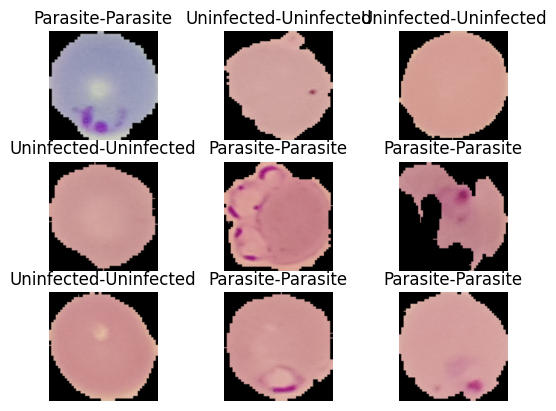

In [ ]:
for image, label in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i])
        plt.title(parasite_prediction(label.numpy()[i])+ "-" + parasite_prediction(model.predict(image)[i][0]))
        plt.axis('off')

In [ ]:
model.save('malaria_model.hdf5')

In [ ]:
lenet_loaded_model = tf.keras.models.load_model('malaria_model.hdf5')

In [ ]:
lenet_loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 220, 220, 6)       456       
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 6)      24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 110, 110, 6)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 106, 106, 16)      2416      
                                                                 
 batch_normalization_1 (Batc  (None, 106, 106, 16)     64        
 hNormalization)                                                 
                                                        

1/1 [==============================] - 0s 29ms/step


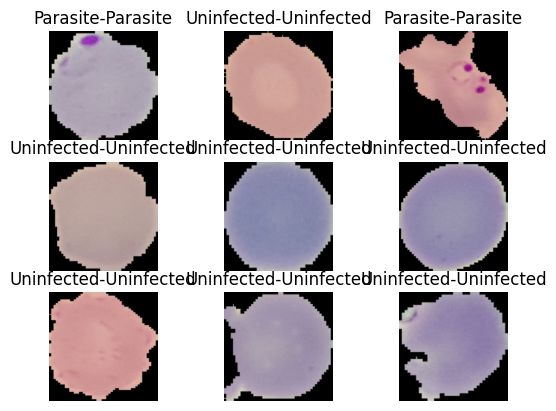

In [ ]:
for image, label in test_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image[i])
        plt.title(parasite_prediction(label.numpy()[i])+ "-" + parasite_prediction(lenet_loaded_model.predict(image)[i][0]))
        plt.axis('off')

### Functional API 

In [23]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomContrast, RandomRotation, Resizing, Rescaling
from tensorflow.keras.models import Model


In [24]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = Conv2D(filters = 6, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(func_input)
x = BatchNormalization()(x)
x = MaxPool2D (pool_size = 2, strides= 2)(x)

x = Conv2D(filters = 16, kernel_size = 3, strides=1, padding='valid', activation = 'relu')(x)
x = BatchNormalization()(x)
output = MaxPool2D (pool_size = 2, strides= 2)(x)

feature_extractor_model = Model(func_input, output, name = "Feature_Extractor")
feature_extractor_model.summary()

Model: "Feature_Extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization_2 (Batc  (None, 222, 222, 6)      24        
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 111, 111, 6)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_3 (Batc  (None, 109, 109, 16

In [25]:
func_input = Input(shape = (IM_SIZE, IM_SIZE, 3), name = "Input Image")

x = feature_extractor_model(func_input)

x = Flatten()(x)

x = Dense(100, activation = "relu")(x)
x = BatchNormalization()(x)

x = Dense(10, activation = "relu")(x)
x = BatchNormalization()(x)

func_output = Dense(1, activation = "sigmoid")(x)

lenet_model_func = Model(func_input, func_output, name = "Lenet_Model")
lenet_model_func.summary()

Model: "Lenet_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input Image (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 Feature_Extractor (Function  (None, 54, 54, 16)       1136      
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 46656)             0         
                                                                 
 dense (Dense)               (None, 100)               4665700   
                                                                 
 batch_normalization_4 (Batc  (None, 100)              400       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 10)                

In [ ]:
!nvidia-smi

Thu Jul 10 22:49:35 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.14                 Driver Version: 566.14         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 2060      WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   75C    P8              8W /   90W |    4656MiB /   6144MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
print(tf.test.is_built_with_cuda()) 

True
